# 06_preprocess_smap — SMAP L3 (SPL3SMP_E) daily 

- **Authenticates** with earthaccess, pulls SPL3SMP_E S3 HDF5 links for date ± 1 day, and reads them from NSIDC (with short-lived S3 creds).
- **Reads** the soil moisture variable (auto-detects the path), applies scale/offset/fill.
- **Merges** multiple days with nanmean to improve coverage.
- **Aligns** to your UTM 200 m template (from step 02) via:
- **Reproject** (default), or
LUT broadcast if ../data/aux/smap_to_template_lut.npz exists (or generate it on the fly if you set broadcast_mode: lut in project.yaml).
- **Writes** ../data/outputs/aligned/smap/smap_sm_utm200m_YYYYMMDD.tif + a small JSON metadata file.

Includes a quicklook plot.


In [2]:
import os
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import yaml, json
import s3fs, h5py
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_origin
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
import earthaccess
print('✅ Imports ready')

✅ Imports ready


In [3]:
cfg = yaml.safe_load(open('../config/project.yaml'))
tgrid = cfg.get('target_grid', {})
template_path = Path(tgrid.get('template_path','../data/outputs/aligned/_grid_template.tif'))
with rasterio.open(template_path) as tmp:
    dst_crs, dst_transform = tmp.crs, tmp.transform
    dst_height, dst_width = tmp.height, tmp.width
    dst_nodata = tmp.nodata
print('Template:', template_path, '| shape:', (dst_height, dst_width))

Template: ../data/outputs/aligned/_grid_template.tif | shape: (623, 469)


In [5]:
earthaccess.login(persist=True)
aws = earthaccess.get_s3_credentials(daac="NSIDC")


fs = s3fs.S3FileSystem(
    key=aws["accessKeyId"],
    secret=aws["secretAccessKey"],
    token=aws["sessionToken"],
    client_kwargs={"region_name": "us-west-2"},
    requester_pays=True,
    s3_additional_kwargs={"RequestPayer": "requester"}  # important for NSIDC
)
print('✅ NSIDC S3 ready')

✅ NSIDC S3 ready


In [30]:
date_center = os.environ.get('SMAP_DATE', cfg.get('smap',{}).get('date','2019-07-26'))
center = datetime.fromisoformat(str(date_center))
start = (center - timedelta(days=1)).strftime('%Y-%m-%d')
end   = (center + timedelta(days=1)).strftime('%Y-%m-%d')
SHORT_NAME = cfg.get('smap',{}).get('short_name','SPL3SMP_E')
print(f'Searching {SHORT_NAME} {start}..{end}')
SM_PATHS = [
 '/Soil_Moisture_Retrieval_Data_AM/soil_moisture',
 '/Soil_Moisture_Retrieval_Data_PM/soil_moisture_pm',
]
ease = cfg.get('EASE2grid',{})
src_crs = CRS.from_string(ease.get('crs','EPSG:6933'))
px = float(ease.get('M09'))
ulx_global = float(ease.get('ulx', -17367530.445))
uly_global = float(ease.get('uly',   7314540.702))
print('EASE2 origin:', ulx_global, uly_global, 'px=', px)

Searching SPL3SMP_E 2019-07-25..2019-07-27
EASE2 origin: -17367530.44 7314540.83 px= 9008.05


In [31]:

granules = (earthaccess.DataGranules()
            .short_name(SHORT_NAME)
            .temporal(start, end)
            .cloud_hosted(True)
            .get())
print('Granules:', len(granules))


Granules: 3


In [32]:
def https_to_s3(url: str) -> str:
    """
    Convert NSIDC Earthdata Cloud HTTPS link to S3 URI.
    Example:
    https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/SMAP/SPL3SMP_E/006/2019/07/25/SMAP_L3_SM_P_E_20190725_R19240_001.h5
    -> s3://nsidc-cumulus-prod-protected/SMAP/SPL3SMP_E/006/2019/07/25/SMAP_L3_SM_P_E_20190725_R19240_001.h5
    """
    prefix = "https://data.nsidc.earthdatacloud.nasa.gov/"
    if url.startswith(prefix):
        return "s3://" + url[len(prefix):]
    # (Rare older domains) normalize if you run into them:
    legacy = "https://n5eil01u.ecs.nsidc.org/"
    if url.startswith(legacy):
        # Those aren’t the cloud-hosted ones; you should re-query with cloud_hosted=True,
        # but if needed you can still strip the domain and prepend s3://nsidc-cumulus-prod-protected/
        return "s3://nsidc-cumulus-prod-protected/" + url[len(legacy):]
    return url  # if it's already s3:// just return as-is
# Build S3 list from earthaccess links:
s3_links = []
for g in granules:
    for link in g.data_links():  # strings
        if link.endswith(".h5"):
            s3_links.append(https_to_s3(link))

print("S3 links:", *s3_links, sep="\n- ")    

S3 links:
- s3://nsidc-cumulus-prod-protected/SMAP/SPL3SMP_E/006/2019/07/25/SMAP_L3_SM_P_E_20190725_R19240_001.h5
- s3://nsidc-cumulus-prod-protected/SMAP/SPL3SMP_E/006/2019/07/26/SMAP_L3_SM_P_E_20190726_R19240_001.h5
- s3://nsidc-cumulus-prod-protected/SMAP/SPL3SMP_E/006/2019/07/27/SMAP_L3_SM_P_E_20190727_R19240_001.h5


In [42]:
from rasterio.transform import from_origin
def _pick_sm_dataset(h5):
    for p in SM_PATHS:
        if p in h5: return p
    for k in h5.keys():
        if isinstance(h5[k], h5py.Group) and 'Soil' in k:
            for kk in h5[k].keys():
                if 'soil_moisture' in kk:
                    return f'/{k}/{kk}'
    raise KeyError('soil_moisture dataset not found')

def _read_smap_sm_array(s3_href, fs):
    path = s3_href.replace('s3://','')
    with fs.open(path,'rb') as fobj, h5py.File(fobj,'r') as h5:
        dpath = _pick_sm_dataset(h5)
        dset = h5[dpath]
        arr = np.array(dset[...], dtype='float32')
        fill=None; scale=1.0; offset=0.0
        for k in ('_FillValue','fillValue','FillValue','MissingValue','missing_value'):
            if k in dset.attrs: fill=float(np.array(dset.attrs[k]).squeeze()); break
        if 'scale_factor' in dset.attrs: scale=float(np.array(dset.attrs['scale_factor']).squeeze())
        if 'add_offset' in dset.attrs: offset=float(np.array(dset.attrs['add_offset']).squeeze())
        if fill is not None: arr = np.where(arr==fill, np.nan, arr)
        if scale!=1.0 or offset!=0.0: arr = arr*scale + offset
        ny, nx = arr.shape
        src_transform = from_origin(ulx_global, uly_global, px, px)
        return arr, src_crs, src_transform

def _merge_nanmean(arrs):
    stk = np.stack(arrs, axis=0)
    with np.errstate(invalid='ignore'): return np.nanmean(stk, axis=0)
print('✅ Helpers ready')

✅ Helpers ready


In [43]:
src_arrays=[]
for link in s3_links:
    try:
        a, crs_a, tr_a = _read_smap_sm_array(link, fs)
        src_arrays.append((a, crs_a, tr_a))
        print('✔ read', link)
    except Exception as e:
        print('skip', link, e)
if not src_arrays: raise RuntimeError('No arrays read')
sm_arrays=[x[0] for x in src_arrays]
src_crs_a = src_arrays[0][1]
src_transform_a = src_arrays[0][2]
sm_merged = _merge_nanmean(sm_arrays)
print('merged shape:', sm_merged.shape)

✔ read s3://nsidc-cumulus-prod-protected/SMAP/SPL3SMP_E/006/2019/07/25/SMAP_L3_SM_P_E_20190725_R19240_001.h5
✔ read s3://nsidc-cumulus-prod-protected/SMAP/SPL3SMP_E/006/2019/07/26/SMAP_L3_SM_P_E_20190726_R19240_001.h5
✔ read s3://nsidc-cumulus-prod-protected/SMAP/SPL3SMP_E/006/2019/07/27/SMAP_L3_SM_P_E_20190727_R19240_001.h5
merged shape: (1624, 3856)


/tmp/ipykernel_3141/1105028187.py:31: RuntimeWarning: Mean of empty slice
  with np.errstate(invalid='ignore'): return np.nanmean(stk, axis=0)


In [46]:
# --- A) Clip merged SMAP (EASE2) to your ROI and save as .npz ---

import pyproj
from shapely.geometry import box
from rasterio.windows import Window

# ROI from config (lon/lat in degrees)
roi_cfg = cfg.get("roi", {})
west, south, east, north = roi_cfg["west"], roi_cfg["south"], roi_cfg["east"], roi_cfg["north"]

# 1) Project ROI lon/lat -> SMAP CRS (EASE2)
to_src = pyproj.Transformer.from_crs("EPSG:4326", src_crs, always_xy=True).transform
xw, ys = to_src(west, south)
xe, yn = to_src(east, north)
# Create projected bbox (make sure min/max are ordered)
xmin, xmax = min(xw, xe), max(xw, xe)
ymin, ymax = min(ys, yn), max(ys, yn)

# 2) Map to SMAP row/col via inverse affine
inv = ~src_transform_a  # inverse of EASE2 transform
cmin = int(np.floor(inv * (xmin, ymax))[0])  # (col, row) from (x,y)
rmin = int(np.floor(inv * (xmin, ymax))[1])
cmax = int(np.ceil(inv * (xmax, ymin))[0])
rmax = int(np.ceil(inv * (xmax, ymin))[1])

# Clip to array bounds
ny, nx = sm_merged.shape
rmin = max(0, rmin); rmax = min(ny, rmax)
cmin = max(0, cmin); cmax = min(nx, cmax)

# 3) Extract window and derive its own transform
sm_clip = sm_merged[rmin:rmax, cmin:cmax].astype("float32", copy=False)

from rasterio.transform import Affine
# Upper-left corner of the window in SMAP CRS
ulx_win = src_transform_a.c + cmin * src_transform_a.a + rmin * src_transform_a.b
uly_win = src_transform_a.f + cmin * src_transform_a.d + rmin * src_transform_a.e
# Window transform uses same pixel sizes/orientation as source
src_transform_clip = Affine(src_transform_a.a, src_transform_a.b, ulx_win,
                            src_transform_a.d, src_transform_a.e, uly_win)

# 4) Save compact NPZ with data + minimal georeferencing
clip_dir = Path("../data/outputs/smap_merge_9km"); clip_dir.mkdir(parents=True, exist_ok=True)
tag = center.strftime("%Y%m%d")
npz_path = clip_dir / f"smap_sm_3day_clip_{tag}.npz"
np.savez_compressed(
    npz_path,
    sm=sm_clip,
    # store transform as 6 numbers (Affine to tuple)
    transform=np.array([src_transform_clip.a, src_transform_clip.b, src_transform_clip.c,
                        src_transform_clip.d, src_transform_clip.e, src_transform_clip.f], dtype="float64"),
    crs=str(src_crs),
    rmin=rmin, cmin=cmin, shape=np.array(sm_merged.shape, dtype="int32")
)
print("✅ Saved native clipped SMAP:", npz_path)


✅ Saved native clipped SMAP: ../data/outputs/smap_merge_9km/smap_sm_3day_clip_20190726.npz


In [47]:
# --- B) Build LUT once (template -> SMAP native) ---
aux_dir = Path("../data/aux"); aux_dir.mkdir(parents=True, exist_ok=True)
lut_path = aux_dir / "smap_to_template_lut.npz"

if not lut_path.exists():
    print("Building SMAP→template LUT ...")
    rows = np.arange(dst_height); cols = np.arange(dst_width)
    cc, rr = np.meshgrid(cols, rows)

    # Template index -> template CRS coords
    def ij_to_xy(T, i, j):
        x = T.c + j*T.a + i*T.b; y = T.f + j*T.d + i*T.e; return x, y
    x_dst, y_dst = ij_to_xy(dst_transform, rr, cc)

    # Reproject to SMAP CRS
    to_smap = pyproj.Transformer.from_crs(dst_crs, src_crs, always_xy=True).transform
    xs, ys = to_smap(x_dst, y_dst)

    # Map to SMAP row/col via inverse source transform (full-grid)
    inv_full = ~src_transform_a  # from the *full EASE2 grid*, not the clip
    cs = np.rint(inv_full.c + xs*inv_full.a + ys*inv_full.b).astype("int32")
    rs = np.rint(inv_full.f + xs*inv_full.d + ys*inv_full.e).astype("int32")
    valid = (rs>=0)&(rs<ny)&(cs>=0)&(cs<nx)

    np.savez_compressed(lut_path, rs=rs, cs=cs, valid=valid, src_shape=np.array([ny, nx], dtype="int32"))
    print("✅ LUT saved:", lut_path)
else:
    print("LUT already exists:", lut_path)


LUT already exists: ../data/aux/smap_to_template_lut.npz


✅ Broadcast complete: (623, 469)


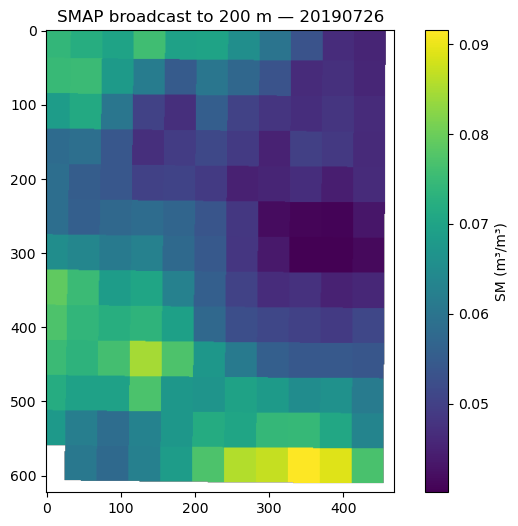

In [48]:
# --- C) Broadcast clipped SMAP to 200 m on demand ---
# 1) Load clipped NPZ
npz = np.load(npz_path)
sm_clip   = npz["sm"]
t_vals    = npz["transform"].tolist()
src_tr_clip = Affine(*t_vals)            # Affine from the clip NPZ
src_crs_clip = CRS.from_string(str(npz["crs"]))
rmin = int(npz["rmin"]); cmin = int(npz["cmin"])
src_shape_full = tuple(npz["shape"])     # original full SMAP shape (ny, nx)

# 2) Load LUT (computed for full EASE2)
lut = np.load(lut_path)
rs_full, cs_full, valid = lut["rs"], lut["cs"], lut["valid"]
assert tuple(lut["src_shape"]) == src_shape_full, "LUT source shape mismatch; rebuild LUT."

# 3) Convert full-grid indices to *clip-relative* indices
#   Any template pixel that maps outside the clip window becomes invalid
rs_rel = rs_full - rmin
cs_rel = cs_full - cmin
valid_clip = valid & (rs_rel>=0) & (cs_rel>=0) & (rs_rel<sm_clip.shape[0]) & (cs_rel<sm_clip.shape[1])

# 4) Take values into a 200 m array
dst_sm = np.full((dst_height, dst_width), np.nan, dtype="float32")
flat = dst_sm.ravel()
flat_valid = valid_clip.ravel()
idx_rel = (rs_rel.ravel() * sm_clip.shape[1] + cs_rel.ravel())
vals = np.full_like(flat, np.nan, dtype="float32")
vals[flat_valid] = sm_clip.ravel()[idx_rel[flat_valid]]
dst_sm = vals.reshape(dst_sm.shape)

print("✅ Broadcast complete:", dst_sm.shape)

# (optional) quicklook
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
im = plt.imshow(dst_sm, cmap="viridis")
plt.colorbar(im, label="SM (m³/m³)")
plt.title(f"SMAP broadcast to 200 m — {tag}")
plt.show()


✅ Wrote: ../data/outputs/aligned/smap/smap_sm_utm200m_20190726.tif


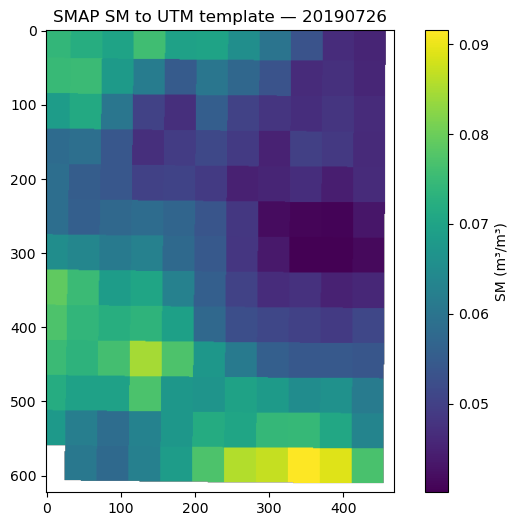

In [49]:
# --- D) If you want to save the 200m SMAP broadcast data

out_dir = Path('../data/outputs/aligned/smap'); out_dir.mkdir(parents=True, exist_ok=True)
tag = center.strftime('%Y%m%d')
out_path = out_dir / f'smap_sm_utm200m_{tag}.tif'
with rasterio.open(template_path) as tmp: profile = tmp.profile
profile.update(dtype='float32', count=1, compress='deflate', tiled=True, nodata=np.nan)
with rasterio.open(out_path, 'w', **profile) as ds: ds.write(dst_sm, 1)
with open(out_dir / f'smap_sm_utm200m_{tag}_meta.json','w') as f:
    json.dump({'short_name':SHORT_NAME,'date_center':center.strftime('%Y-%m-%d'),
               'range':[start,end],'sources':s3_links,
               'method':'reproject' if (mode=='reproject' or not Path('../data/aux/smap_to_template_lut.npz').exists()) else 'lut'}, f, indent=2)
print('✅ Wrote:', out_path)
plt.figure(figsize=(8,6)); im=plt.imshow(dst_sm, cmap='viridis'); plt.colorbar(im,label='SM (m³/m³)');
plt.title(f'SMAP SM to UTM template — {tag}'); plt.show()